## VGG-19 for Brain Tumor Image Classification - Transfer Learning 

In [2]:
import os 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg


import tensorflow as tf
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Flatten, Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print('Imported Libraries')

Imported Libraries


### Define Data paths

In [3]:
train_path = 'Brain Tumor Classification (MRI)/Training'
test_path = 'Brain Tumor Classification (MRI)/Testing'

In [4]:
for folder in os.listdir(train_path):
    sub_dir = train_path + "/" + folder

    print(folder)


glioma_tumor
meningioma_tumor
no_tumor
pituitary_tumor


glioma_tumor


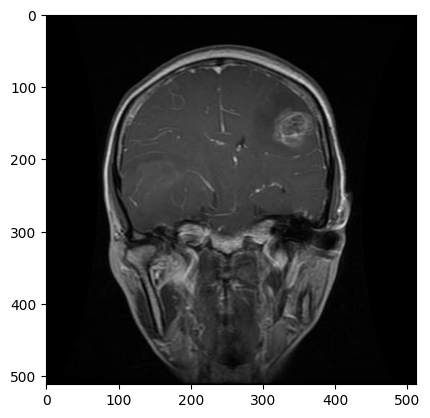

Skipping directory: Brain Tumor Classification (MRI)/Training/glioma_tumor/.ipynb_checkpoints
meningioma_tumor


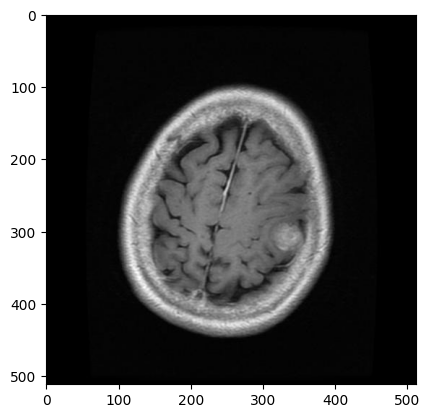

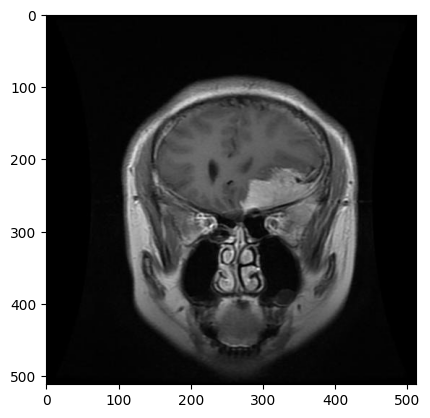

no_tumor


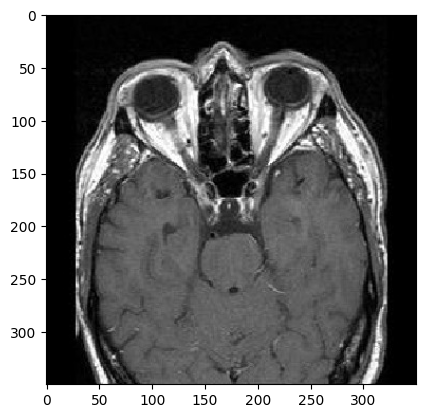

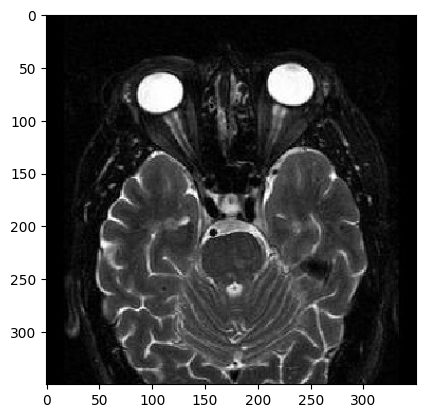

pituitary_tumor


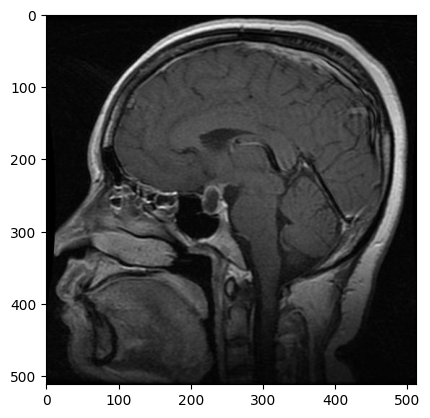

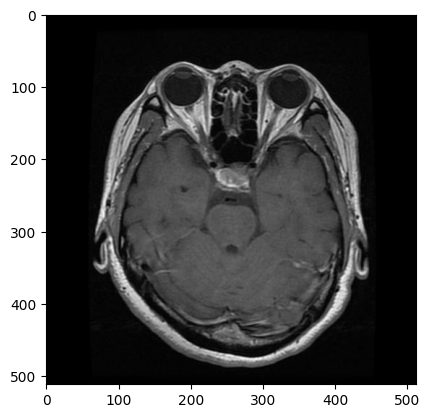

In [5]:
for folder in os.listdir(train_path):
    # Create the correct full path to the class directory
    sub_dir = os.path.join(train_path, folder)
    print(folder)

    # Check if the path is a directory
    if os.path.isdir(sub_dir):
        # List the contents of the directory
        contents = os.listdir(sub_dir)

        # Loop through a few items in the directory (you can change range(2) to process more)
        for i in range(2):
            if i < len(contents):
                # Get the name of the file or directory
                item_name = contents[i]
                
                # Create the full path to the item
                item_path = os.path.join(sub_dir, item_name)

                # Check if the item is a file before trying to read it as an image
                if os.path.isfile(item_path):
                    try:
                        img = mpimg.imread(item_path)
                        implot = plt.imshow(img)
                        plt.show()
                    except Exception as e:
                        print(f"Error reading {item_path}: {e}")
                else:
                    # This code block handles the case where the item is a directory
                    print(f"Skipping directory: {item_path}")

### Preparing Traing, validation and Test set 

In [6]:
def Preprocessing(image_size = (64,64), batch_size = 8 , validation_split = 0.1):
    
    ## create the training set
    train = image_dataset_from_directory(
        train_path,
        labels= 'inferred',
        image_size = image_size,
        batch_size = batch_size,
        shuffle = True,
        validation_split = validation_split,
        subset = 'training',
        seed = 123
    )
    
    ## create the validation set
    val = image_dataset_from_directory(
        train_path,
        labels= 'inferred',
        image_size = image_size,
        batch_size = batch_size,
        shuffle = True,
        validation_split = validation_split,
        subset = 'validation',
        seed = 123
    )
    ## create the test set 
    test = image_dataset_from_directory(
        test_path,
        labels= 'inferred',
        image_size = image_size,
        batch_size = batch_size
    )
    return train, val, test    

In [8]:
train, val, test = Preprocessing()

Found 2871 files belonging to 4 classes.
Using 2584 files for training.
Found 2871 files belonging to 4 classes.
Using 287 files for validation.
Found 394 files belonging to 4 classes.


#### Check for classes

In [9]:
num_classes = len(train.class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train.class_names}")

print('----------------------------------')

num_classes = len(val.class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {val.class_names}")

print('----------------------------------')

num_classes = len(test.class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {test.class_names}")

Number of classes: 4
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
----------------------------------
Number of classes: 4
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
----------------------------------
Number of classes: 4
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


#### Inspect the datasets if loaded properly 

In [10]:
print(f"Number of batches in training set: {tf.data.experimental.cardinality(train).numpy()}")
print('----------------------------------')
print(f"Number of batches in validation set: {tf.data.experimental.cardinality(val).numpy()}")
print('----------------------------------')
print(f"Number of batches in test set: {tf.data.experimental.cardinality(test).numpy()}")

Number of batches in training set: 323
----------------------------------
Number of batches in validation set: 36
----------------------------------
Number of batches in test set: 50


## VGG-19 Model 

In [12]:
INPUT_SHAPE = (64, 64, 3)
VGG19_IMG_SHAPE = (64, 64, 3)

inputs = layers.Input(shape=INPUT_SHAPE)

X = layers.Rescaling(1./255)(inputs)
X = layers.RandomFlip("horizontal")(X)
X = layers.RandomRotation(0.1)(X)
X = layers.RandomZoom(0.2)(X)
X = layers.RandomTranslation(0.1, 0.1)(X)
X = layers.Resizing(VGG19_IMG_SHAPE[0], VGG19_IMG_SHAPE[1])(X)

VGG19_model = VGG19(input_shape=VGG19_IMG_SHAPE,
                  weights='imagenet',
                  include_top=False)

VGG19_model.trainable = False

X = VGG19_model(X, training=False)  
X = layers.Flatten()(X)
X = layers.Dense(256, activation='relu')(X)
X = layers.Dropout(0.5)(X)
Prediction = layers.Dense(4, activation='softmax')(X)

model = Model(inputs=inputs, outputs=Prediction)
model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
early_stop = EarlyStopping(monitor="val_loss", mode='min', patience=5)
History = model.fit(train, validation_data=val, epochs=30, callbacks=[early_stop], batch_size=8)

Epoch 1/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - accuracy: 0.4353 - loss: 1.3493 - val_accuracy: 0.6202 - val_loss: 0.9162
Epoch 2/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - accuracy: 0.5663 - loss: 1.0389 - val_accuracy: 0.6725 - val_loss: 0.8518
Epoch 3/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.5663 - loss: 0.9753 - val_accuracy: 0.7073 - val_loss: 0.8082
Epoch 4/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 47s 144ms/step - accuracy: 0.5956 - loss: 0.9280 - val_accuracy: 0.7213 - val_loss: 0.7323
Epoch 5/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - accuracy: 0.6154 - loss: 0.9046 - val_accuracy: 0.6794 - val_loss: 0.8022
Epoch 6/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - accuracy: 0.6137 - loss: 0.8912 - val_accuracy: 0.7352 - val_loss: 0.6990
Epoch 7/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 45s 139ms/step - accuracy: 0.6192 - loss: 0.8669 - val_accuracy: 0.7422 - val_loss: 0.6925
Epoch 8/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.6471 - loss: 0

#### Evaluate, Save and Load model 

In [13]:
def Evaluate_model():
    loss,accuracy = model.evaluate(test)
    print(f'Test Loss : {loss:.2f}')
    print(f'Test Accuracy : {accuracy * 100:.2f}')

    
def Save_model(path = 'models/ResNet_Model.keras'):
    if model is None:
        raise valuerror('Model not trained')    
    model.save(path)
    print('Model saved Successfully ')

def load_saved_model(path = 'models/ResNet_Model.keras'):
    model = tf.keras.models.load_model(path)
    print('Model loaded successfully')
    self.model.summary()

In [14]:
Evaluate_model()

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.4119 - loss: 2.7209
Test Loss : 2.43
Test Accuracy : 42.13


In [15]:
Save_model()

Model saved Successfully 


###  Failed miserably 